In [113]:
from grizli import model
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
mosaic = '/Users/vestrada/Downloads/goodss_3dhst.v4.0.F160W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat'
instrument = 'G102' # or G141

galaxy_id = 41520

ref_cat = Table.read(catalog ,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [17]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 < pos[0] < xpixlim and 0 < pos[1] < ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [18]:
flt_files = glob('/Users/vestrada/Clear_data/s_flt_files/*')


goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

In [12]:
orient_1 = '/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits' 


In [20]:
flt = model.GrismFLT(grism_file = orient_1 ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
# catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat,sextractor=False)

Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot reference /Users/vestrada/Downloads/goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [71]:
flt.compute_full_model(ids=seg_cat['id'],)
beam = flt.object_dispersers[galaxy_id][2]['A']

In [42]:
co = model.BeamCutout(flt, beam, conf=flt.conf,min_mask=-.1)


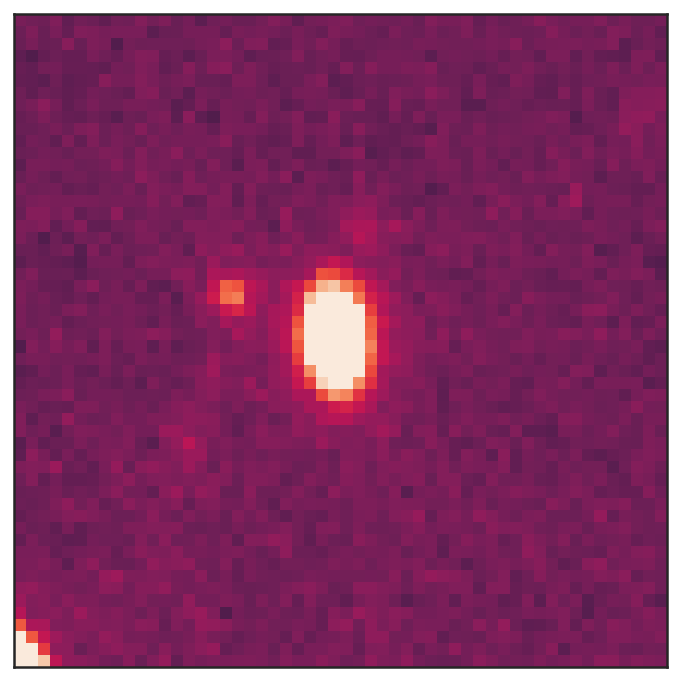

In [104]:
plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/41520_direct.png')

(-2.5e-21, 6e-21)

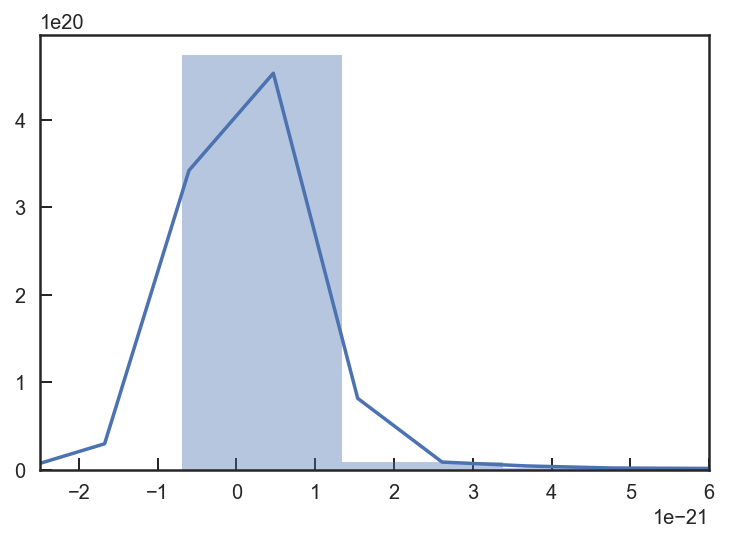

In [89]:
sea.distplot(np.arcsinh(beam.direct.flat))
plt.xlim(-.25E-20,.6E-20)

In [105]:
mosaic = '/Users/vestrada/Downloads/goodsn_3dhst.v4.0.F160W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.3.cat'
instrument = 'G102' # or G141

galaxy_id = 21156

ref_cat = Table.read(catalog ,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [106]:
flt_files = glob('/Users/vestrada/Clear_data/n_flt_files/*')


goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

x=152.3 y=310.9, PA=345.0, file=icat21cfq_flt.fits 
x=227.3 y=314.4, PA=345.0, file=icat21coq_flt.fits 
x=158.8 y=320.9, PA=345.0, file=icat21dgq_flt.fits 
x=148.8 y=317.4, PA=345.0, file=icat21dlq_flt.fits 
x=-26.3 y=850.8, PA=195.0, file=icat25hcq_flt.fits 
x=-16.3 y=854.3, PA=195.0, file=icat25hiq_flt.fits 
x=-19.8 y=860.8, PA=195.0, file=icat25icq_flt.fits 
x=-29.9 y=857.4, PA=195.0, file=icat25iiq_flt.fits 
x=279.9 y=838.7, PA=345.0, file=icxt51jvq_flt.fits 
x=289.9 y=842.2, PA=345.0, file=icxt51jwq_flt.fits 
x=286.4 y=848.7, PA=345.0, file=icxt51jzq_flt.fits 
x=276.4 y=845.2, PA=345.0, file=icxt51k1q_flt.fits 
x=128.7 y=708.3, PA=308.9, file=icxt52i0q_flt.fits 
x=138.7 y=711.8, PA=308.9, file=icxt52i1q_flt.fits 
x=135.1 y=718.3, PA=308.9, file=icxt52i4q_flt.fits 
x=125.1 y=714.9, PA=308.9, file=icxt52i6q_flt.fits 
x=128.7 y=708.2, PA=308.9, file=icxt53i9q_flt.fits 
x=138.7 y=711.7, PA=308.9, file=icxt53iaq_flt.fits 
x=135.2 y=718.3, PA=308.9, file=icxt53idq_flt.fits 
x=125.2 y=71

In [109]:
orient_1 = '/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits' 


In [114]:
flt = model.GrismFLT(grism_file = orient_1 ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
# catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat,sextractor=False)

Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot reference /Users/vestrada/Downloads/goodsn_3dhst.v4.0.F160W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [115]:
flt.compute_full_model(ids=seg_cat['id'],)
beam = flt.object_dispersers[galaxy_id][2]['A']

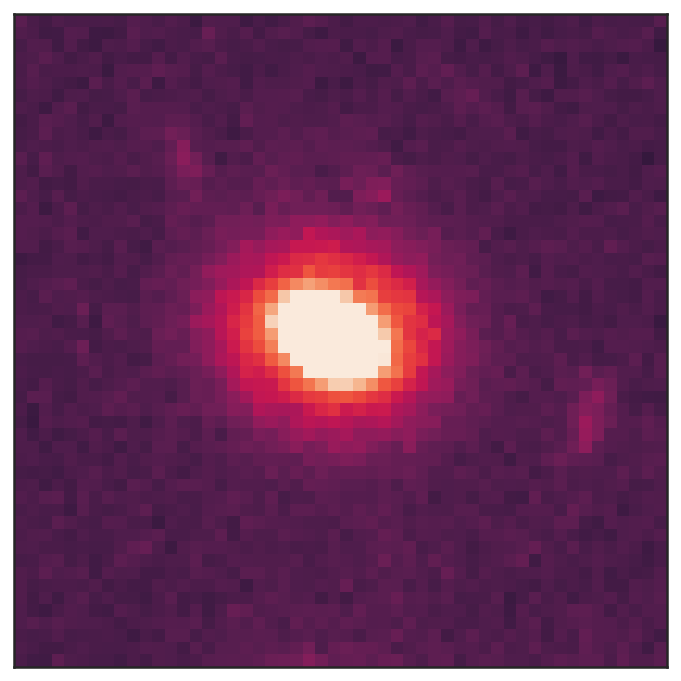

In [119]:
plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=1E-20)
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/21156_direct.png')

(-2.5e-21, 1e-20)

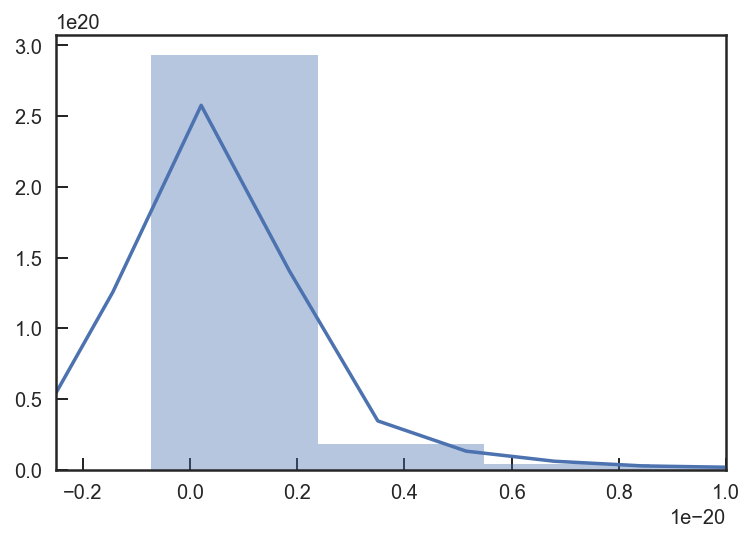

In [118]:
sea.distplot(np.arcsinh(beam.direct.flat))
plt.xlim(-.25E-20,1E-20)